<a href="https://colab.research.google.com/github/moarshy/PyTorch-Projects/blob/main/Tabular_PyTorch_Fastai_AdultDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   In this colab notebook, we practice applying deep learning to tabular data
*   We use both PyTorch to implement from the basics and use the amazing fastai library

The following amzing blogs/notebooks were very helpful
*   https://walkwithfastai.com/tab.clas.binary
*   https://jovian.ai/aakanksha-ns/shelter-outcome







In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [29]:
#importing the necessary libraries
from pathlib import Path
import zipfile
from tqdm import tqdm_notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [6]:
# installing the fastai library. Must be done everytime the notebook is open
!pip install -U fastai -q

     |████████████████████████████████| 194kB 8.4MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 


In [7]:
from fastai.tabular.all import *

# Download the data



In [8]:
base_path = Path('/content/drive/My Drive/Colab Notebooks/Portfolio/Tabular/Adult')
#path = untar_data(URLs.ADULT_SAMPLE, dest=base_path)

# Dataset class, model class and training function using PyTorch

In [9]:
#we build a dataset class
class AdultDataset():
    def __init__(self, x, y, catcols, contcols):
        
        self.x = x.copy()
        self.y = y.copy()
        
        self.cat_features = self.x.loc[:, catcols].values
        self.cont_features = self.x.loc[:, contcols].values
        self.y = self.y.values
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        to_return = {
            'x_cat' : torch.tensor(self.cat_features[idx, :], dtype=torch.long),
            'x_cont' : torch.tensor(self.cont_features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.y[idx], dtype=torch.float)            
        }
        return to_return

In [31]:
#this is our model. 
#It uses embedding layer for categorical columns and then concate both the embedding layer and continuous features to be used in the subsequent layers
#we initialise the layers following - embedding --> uniform, linear --> kaiming uniform, batchnorm --> constant
class Model(nn.Module):
    def __init__(self, n_cont, num_targets, hidden_size, embedding_size):
        super(Model, self).__init__()
        
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories, size in embedding_size])
        n_emb = sum(e.embedding_dim for e in self.embeddings) 
        self.n_emb, self.n_cont = n_emb, n_cont
        
        self.bn0 = nn.BatchNorm1d(self.n_cont)
        self.lin1 = nn.Linear(in_features=self.n_emb + self.n_cont, out_features=hidden_size[0])
        self.bn1 = nn.BatchNorm1d(hidden_size[0])
        self.dropout1 = nn.Dropout(0.4)
        self.relu1 = nn.PReLU()
        self.emb_drop = nn.Dropout(0.6)
        
        self.hidden = nn.ModuleList()
        for k in range(1, len(hidden_size)):
            self.hidden.append(nn.Linear(in_features=hidden_size[k-1], out_features=hidden_size[k]))
            self.hidden.append(nn.BatchNorm1d(hidden_size[k]))
            self.hidden.append(nn.Dropout(0.5))
            self.hidden.append(nn.PReLU())
    
        self.out = nn.Linear(hidden_size[-1], num_targets)
        self.initialize_weights()
        
    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        x2 = self.bn0(x_cont)
        x = torch.cat([x, x2], 1)
        x = self.lin1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.relu1(x)
        
        for l in self.hidden:
            x = l(x)
        
        x = self.out(x)
    
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
            
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Embedding):
                nn.init.uniform_(m.weight, -1., 1.)

In [87]:
#we build a training function
def training(epochs, trainloader, validloader, loss_fn, optimizer, scheduler):
  history = []
  for epoch in range(epochs):
    model.train()

    train_loss = 0
    loop = tqdm_notebook(enumerate(trainloader), leave=False, total=len(trainloader))
    for i, data in loop:
        
        x_cat, x_cont, targets = data['x_cat'].to(device), data['x_cont'].to(device), data['y']
        targets = targets.type(torch.LongTensor).to(device)

        output = model(x_cat, x_cont)
        loss = loss_fn(output, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

        loop.set_description(f'Epoch {epoch}/{epochs}')
        loop.set_postfix(loss=loss.item())

    train_loss /= len(trainloader)

    model.eval()
    valid_loss = 0
    valid_preds = []
    correct, total, acc  = [0]*3

    with torch.no_grad():
      for data in validloader:
          x_cat, x_cont, targets = data['x_cat'].to(device), data['x_cont'].to(device), data['y']
          targets = targets.type(torch.LongTensor).to(device)

          output = model(x_cat, x_cont)
          loss = loss_fn(output, targets)
          
          valid_loss += loss.item()

          output = torch.log_softmax(output, dim=1)
          _, pred = torch.max(output, 1)
          correct += (pred == targets).sum().item()
          total += len(pred)

          valid_preds.append(output.detach().cpu().numpy())

    valid_loss /= len(validloader)
    acc = correct/total
    print(f'Epoch: {epoch}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Accuracy: {acc:.2f}')
    history.append((epoch, train_loss, valid_loss, acc))

  return history, valid_preds

# Exploring the data



In [88]:
df = pd.read_csv(base_path/'adult_sample/adult.csv')

In [89]:
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32561 non-null  int64  
 1   workclass       32561 non-null  object 
 2   fnlwgt          32561 non-null  int64  
 3   education       32561 non-null  object 
 4   education-num   32074 non-null  float64
 5   marital-status  32561 non-null  object 
 6   occupation      32049 non-null  object 
 7   relationship    32561 non-null  object 
 8   race            32561 non-null  object 
 9   sex             32561 non-null  object 
 10  capital-gain    32561 non-null  int64  
 11  capital-loss    32561 non-null  int64  
 12  hours-per-week  32561 non-null  int64  
 13  native-country  32561 non-null  object 
 14  salary          32561 non-null  object 
dtypes: float64(1), int64(5), object(9)
memory usage: 3.7+ MB


In [91]:
#we fillna the education-num with the mode
df['education-num'] = df['education-num'].fillna(df['education-num'].value_counts().index[0])

In [92]:
#we fillna the occupation with the mode
df['occupation'] = df['occupation'].fillna(df['occupation'].value_counts().index[0])

In [93]:
# Preprocessing 
def preprocess(df, catcols, contcols):
    lbl_enc = {}
    for c in catcols:
        lbl_enc[c] = LabelEncoder()
        df[c] = lbl_enc[c].fit_transform(df[c].values)
      
    mms = {}
    for c in contcols:
      mms[c] = MinMaxScaler()
      df[c] = mms[c].fit_transform(df[c].values.reshape(-1,1))
    
    return df, lbl_enc, mms

def preprocess_target(df, target_column):
    le = LabelEncoder()
    df[target_column] = le.fit_transform(df[target_column].values)

    return df, le

In [96]:
#setting the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#the column lists
in_features = len(features.columns)
classes = df['salary'].nunique()
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cont_names = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
target_col = 'salary'
ncont = len(cont_names)

#preprocess and prepare the train/test split
df, *_ = preprocess(df, cat_names, cont_names)
df, _ = preprocess_target(df, target_col)
features = df.drop('salary', axis=1)
target = df['salary']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33)

#the embedding sizes
embedding = []
for c in cat_names:
  embedding.append((df[c].nunique(), int((df[c].nunique()*1.6)**0.56)))

#hyperparameters
learningrate = 1e-3
batchsize = 512
epochs = 30

#dataset and dataloader
train_ds = AdultDataset(X_train, y_train, cat_names, cont_names)
valid_ds = AdultDataset(X_test, y_test, cat_names, cont_names)

train_dl = DataLoader(train_ds, batch_size=batchsize, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batchsize*2, shuffle=False)

#Model
model = Model(n_cont=ncont, num_targets=classes, hidden_size=[200,100], embedding_size=embedding)
model.to(device)

#criterion, opt, scheduler
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=learningrate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-1, epochs=epochs, steps_per_epoch=len(train_dl))

In [97]:
hist, _ = training(epochs=epochs, trainloader=train_dl, validloader=valid_dl, loss_fn=criterion, optimizer=opt, scheduler=scheduler)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch: 0, Train Loss: 0.5196486364963443, Valid Loss: 0.38697515563531354, Accuracy: 0.83


Epoch: 1, Train Loss: 0.38248428286508074, Valid Loss: 0.33907401832667267, Accuracy: 0.84


Epoch: 2, Train Loss: 0.3566991347213124, Valid Loss: 0.32374312660910864, Accuracy: 0.85


Epoch: 3, Train Loss: 0.3494107251943544, Valid Loss: 0.3209684057669206, Accuracy: 0.85


Epoch: 4, Train Loss: 0.34807287537774373, Valid Loss: 0.3190750696442344, Accuracy: 0.85


Epoch: 5, Train Loss: 0.3467837634474732, Valid Loss: 0.32207068529996, Accuracy: 0.85


Epoch: 6, Train Loss: 0.34404380584872046, Valid Loss: 0.3190893232822418, Accuracy: 0.85


Epoch: 7, Train Loss: 0.34761900333471074, Valid Loss: 0.32183942469683563, Accuracy: 0.85


Epoch: 8, Train Loss: 0.3469194333220637, Valid Loss: 0.3189391006122936, Accuracy: 0.85


Epoch: 9, Train Loss: 0.34523449456968974, Valid Loss: 0.3339819068258459, Accuracy: 0.84


Epoch: 10, Train Loss: 0.34524710095205974, Valid Loss: 0.3321759375658902, Accuracy: 0.84


Epoch: 11, Train Loss: 0.3439806727475898, Valid Loss: 0.31282352046533063, Accuracy: 0.85


Epoch: 12, Train Loss: 0.3437835109788318, Valid Loss: 0.3206509162079204, Accuracy: 0.85


Epoch: 13, Train Loss: 0.3400458485581154, Valid Loss: 0.3411160138520328, Accuracy: 0.82


Epoch: 14, Train Loss: 0.3407954234023427, Valid Loss: 0.31507301330566406, Accuracy: 0.85


Epoch: 15, Train Loss: 0.33334229297416157, Valid Loss: 0.317174339836294, Accuracy: 0.85


Epoch: 16, Train Loss: 0.34001947627511137, Valid Loss: 0.31733701445839624, Accuracy: 0.85


Epoch: 17, Train Loss: 0.3347700993682063, Valid Loss: 0.3185238160870292, Accuracy: 0.85


Epoch: 18, Train Loss: 0.33242073031358943, Valid Loss: 0.32158619978211145, Accuracy: 0.85


Epoch: 19, Train Loss: 0.3322255278742591, Valid Loss: 0.32233683358539233, Accuracy: 0.85


Epoch: 20, Train Loss: 0.3336727432040281, Valid Loss: 0.31968815760179, Accuracy: 0.85


Epoch: 21, Train Loss: 0.3297048412090124, Valid Loss: 0.31396534768017853, Accuracy: 0.85


Epoch: 22, Train Loss: 0.3292164476804955, Valid Loss: 0.31713676994497125, Accuracy: 0.85


Epoch: 23, Train Loss: 0.33147115693535917, Valid Loss: 0.3105173707008362, Accuracy: 0.86


Epoch: 24, Train Loss: 0.3264614073343055, Valid Loss: 0.3114251467314633, Accuracy: 0.85


Epoch: 25, Train Loss: 0.3252730265606281, Valid Loss: 0.31095298853787506, Accuracy: 0.85


Epoch: 26, Train Loss: 0.32373936924823493, Valid Loss: 0.31093217026103626, Accuracy: 0.85


Epoch: 27, Train Loss: 0.322884086952653, Valid Loss: 0.3106734563003887, Accuracy: 0.85


Epoch: 28, Train Loss: 0.32604894873707796, Valid Loss: 0.3112430057742379, Accuracy: 0.85


Epoch: 29, Train Loss: 0.32115016219227815, Valid Loss: 0.31089692495085974, Accuracy: 0.85


# Training with fastai

#the following was taken from the awesome fastai blog - [walkwithfastai](https://walkwithfastai.com/tab.clas.binary)


In [98]:
df = pd.read_csv(base_path/'adult_sample/adult.csv') 

In [99]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cont_names = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
target_col = 'salary'
procs = [Categorify, FillMissing, Normalize]
y_block = CategoryBlock()
splits = RandomSplitter()(range_of(df))

In [100]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=target_col, y_block=y_block, splits=splits)

In [101]:
trn_dl = TabDataLoader(to.train, bs=256, shuffle=True, drop_last=True)
val_dl = TabDataLoader(to.valid, bs=512)
dls = DataLoaders(trn_dl, val_dl)

In [102]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,education-num_na,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary
0,Private,Masters,Married-civ-spouse,Exec-managerial,Husband,White,Male,Japan,False,47.000000,586657.000414,14.0,-0.000004,-4.371089e-07,40.0,>=50k
1,Local-gov,7th-8th,Married-spouse-absent,Other-service,Not-in-family,White,Female,Puerto-Rico,False,42.000000,193537.000186,4.0,-0.000004,-4.371089e-07,35.0,<50k
2,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States,False,61.000000,198078.000308,9.0,-0.000004,-4.371089e-07,40.0,>=50k
3,Local-gov,Bachelors,Divorced,Prof-specialty,Unmarried,Black,Female,United-States,False,43.000000,598995.001651,13.0,-0.000004,-4.371089e-07,42.0,<50k
4,Private,Bachelors,Never-married,Machine-op-inspct,Not-in-family,White,Male,United-States,False,28.000000,203709.999886,13.0,-0.000004,-4.371089e-07,40.0,<50k
5,State-gov,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,False,43.000000,139734.001264,13.0,15023.999754,-4.371089e-07,40.0,>=50k
6,Private,11th,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,False,22.000001,369386.999666,7.0,-0.000004,-4.371089e-07,35.0,<50k
7,Local-gov,Masters,Never-married,Prof-specialty,Not-in-family,White,Female,United-States,False,33.000000,162623.001389,14.0,-0.000004,-4.371089e-07,50.0,<50k
8,Private,HS-grad,Divorced,Tech-support,Own-child,White,Male,United-States,False,37.000000,206698.999482,9.0,-0.000004,-4.371089e-07,45.0,<50k
9,Private,1st-4th,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,Mexico,False,33.000000,231825.999732,2.0,-0.000004,-4.371089e-07,40.0,<50k


In [103]:
emb_szs = get_emb_sz(to); emb_szs

[(10, 6), (17, 8), (8, 5), (16, 8), (7, 5), (6, 4), (3, 3), (43, 13), (3, 3)]

In [104]:
to.cat_names


(#9) ['workclass','education','marital-status','occupation','relationship','race','sex','native-country','education-num_na']

In [105]:
to['workclass'].nunique()

9

In [106]:
cont_len = len(to.cont_names); cont_len

6

In [107]:
net = TabularModel(emb_szs, cont_len, 2, [200,100]); net

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
    (7): Embedding(43, 13)
    (8): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(61, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=61, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [108]:
learn = tabular_learner(dls, [200,100], metrics=accuracy)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.00363078061491251)

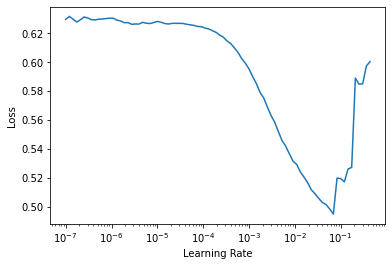

In [109]:
learn.lr_find()


In [110]:
learn.fit(epochs, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.361784,0.335643,0.845977,00:01
1,0.337509,0.323809,0.849969,00:01
2,0.324518,0.322916,0.849355,00:01
3,0.325411,0.321469,0.851966,00:01
4,0.329693,0.325846,0.853194,00:01
5,0.327428,0.370970,0.831388,00:01
6,0.329880,0.349526,0.825860,00:01
7,0.333474,0.341952,0.840448,00:01
8,0.323300,0.344048,0.853194,00:01
9,0.323360,0.324903,0.846898,00:02
